# CAN Workshop- LFADS demo in pytorch

## Import necessary modules

In [1]:
%matplotlib inline

import torch
import torchvision
np = torch._np
import matplotlib.pyplot as plt

import os
import yaml

from lfads import LFADS_Net
from utils import read_data, load_parameters, save_parameters

# plt.style.use('dark_background')

In [2]:
# Select device to train LFADS on
device = 'cuda' if torch.cuda.is_available() else 'cpu'; print('Using device: %s'%device)

Using device: cuda


## Load or Generate Data 

In [3]:
if os.path.exists('./synth_data/chaotic_rnn_300'):
    data_dict = read_data('./synth_data/chaotic_rnn_300')
else:
    if not os.path.isdir('./synth_data'):
        os.mkdir('./synth_data/')
    
    from synth_data_chaotic_rnn import generate_data
    data_dict = generate_data(T= 1, dt_rnn= 0.01, dt_cal= 0.01,
                              Ninits= 400, Ntrial= 10, Ncells= 50, trainp= 0.8,
                              tau=0.025, gamma=1.5, maxRate=30, B=20,
                              seed=300, save=True)

train_data = torch.Tensor(data_dict['train_spikes']).to(device)
valid_data = torch.Tensor(data_dict['valid_spikes']).to(device)

train_truth = torch.Tensor(data_dict['train_rates']).to(device)
valid_truth = torch.tensor(data_dict['valid_rates']).to(device)

train_ds      = torch.utils.data.TensorDataset(train_data)
valid_ds      = torch.utils.data.TensorDataset(valid_data)

num_trials, num_steps, num_cells = train_data.shape
print(train_data.shape)

torch.Size([3200, 100, 50])


## View Example Trial

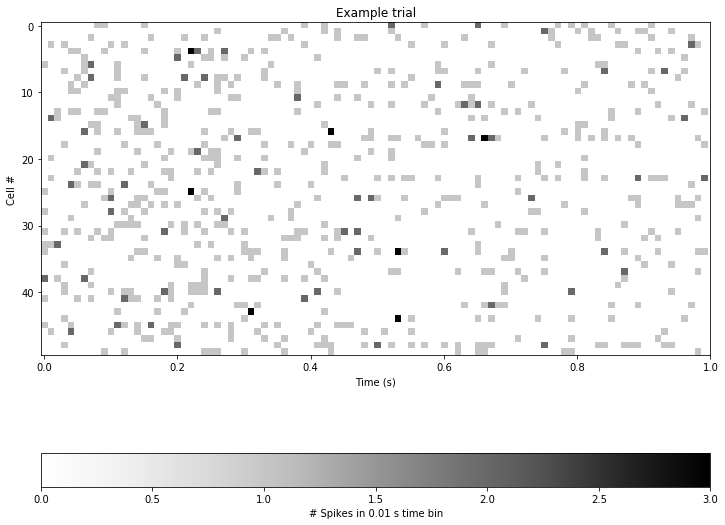

In [4]:
plt.figure(figsize = (12,12))
plt.imshow(data_dict['train_spikes'][0].T, cmap=plt.cm.Greys)
plt.xticks(np.linspace(0, 100, 6), ['%.1f'%i for i in np.linspace(0, 1, 6)])
plt.xlabel('Time (s)')
plt.ylabel('Cell #')
plt.colorbar(orientation='horizontal', label='# Spikes in 0.01 s time bin')
plt.title('Example trial');

## View example Ground Truth Firing Rates

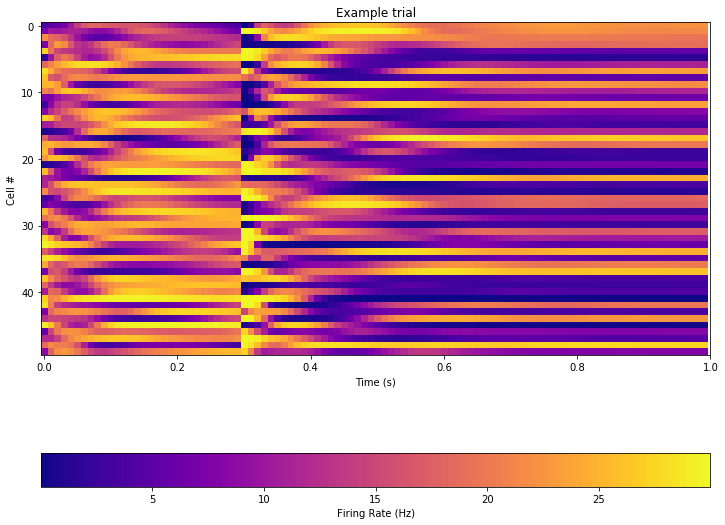

In [5]:
plt.figure(figsize = (12,12))
plt.imshow(data_dict['train_rates'][0].T, cmap=plt.cm.plasma)
plt.xticks(np.linspace(0, 100, 6), ['%.1f'%i for i in np.linspace(0, 1, 6)])
plt.xlabel('Time (s)')
plt.ylabel('Cell #')
plt.colorbar(orientation='horizontal', label='Firing Rate (Hz)')
plt.title('Example trial');

## LFADS Schema
<img src='lfads_schema.png' width=800 align=left>

## Load model hyperparameters 

In [6]:
hyperparams = load_parameters('./parameters_demo.yaml')
save_parameters(hyperparams)
hyperparams

{'betas': (0.9, 0.99),
 'c_encoder_dim': 128,
 'clip_val': 5.0,
 'controller_dim': 128,
 'dataset_name': 'chaotic_rnn',
 'epsilon': 0.1,
 'factors_dim': 20,
 'g0_encoder_dim': 200,
 'g0_prior_kappa': 0.1,
 'g_dim': 200,
 'keep_prob': 0.95,
 'kl_weight_schedule_dur': 2000,
 'kl_weight_schedule_start': 0,
 'l2_con_scale': 0,
 'l2_gen_scale': 2000,
 'l2_weight_schedule_dur': 2000,
 'l2_weight_schedule_start': 0,
 'learning_rate': 0.01,
 'learning_rate_decay': 0.95,
 'learning_rate_min': 1e-05,
 'max_norm': 200,
 'run_name': 'demo',
 'scheduler_cooldown': 6,
 'scheduler_on': True,
 'scheduler_patience': 6,
 'u_dim': 1,
 'u_prior_kappa': 0.1}

## Instantiate LFADS model

In [8]:
model = LFADS_Net(inputs_dim = num_cells, T = num_steps, dt = 0.01, device=device,
                 model_hyperparams=hyperparams).to(device)

Random seed: 3769


#### Pick up where you left off (if you have a recent save) 

In [9]:
# model.load_checkpoint('recent')

## Fit model

Rule of thumb: You can usually see good fit after 200 epochs (~30 mins runtime on Thinkpad GPU, ~2.5 hours on CPU), but to see good inference of perturbation timings need to run for about 800 epochs (~2 hours on Thinkpad GPU).

In [10]:
model.fit(train_ds, valid_ds, max_epochs=200, batch_size=200, use_tensorboard=True,
          train_truth=train_truth, valid_truth=valid_truth)

Beginning training...
Epoch:    1, Step:    16, training loss: 2678.004, validation loss: 3340.258
Epoch:    2, Step:    32, training loss: 2231.734, validation loss: 2650.122
Epoch:    3, Step:    48, training loss: 2155.342, validation loss: 2370.744
Epoch:    4, Step:    64, training loss: 2132.817, validation loss: 2301.345
Epoch:    5, Step:    80, training loss: 2122.175, validation loss: 2266.808
Epoch:    6, Step:    96, training loss: 2116.106, validation loss: 2259.606
Epoch:    7, Step:   112, training loss: 2108.942, validation loss: 2256.436
Epoch:    8, Step:   128, training loss: 2107.156, validation loss: 2292.228
Epoch:    9, Step:   144, training loss: 2115.339, validation loss: 2252.597
Epoch:   10, Step:   160, training loss: 2108.981, validation loss: 2240.514
Epoch:   11, Step:   176, training loss: 2105.172, validation loss: 2224.779
Epoch:   12, Step:   192, training loss: 2106.449, validation loss: 2220.495
Epoch:   13, Step:   208, training loss: 2102.512, val

## Load checkpoint with lowest validation error 

In [11]:
model.load_checkpoint('best')

## Plot results summary 

{'factors': <Figure size 576x576 with 20 Axes>,
 'inputs': <Figure size 576x108 with 1 Axes>,
 'rsq': <Figure size 432x288 with 1 Axes>,
 'traces': <Figure size 576x576 with 12 Axes>,
 'truth': <Figure size 576x576 with 12 Axes>}

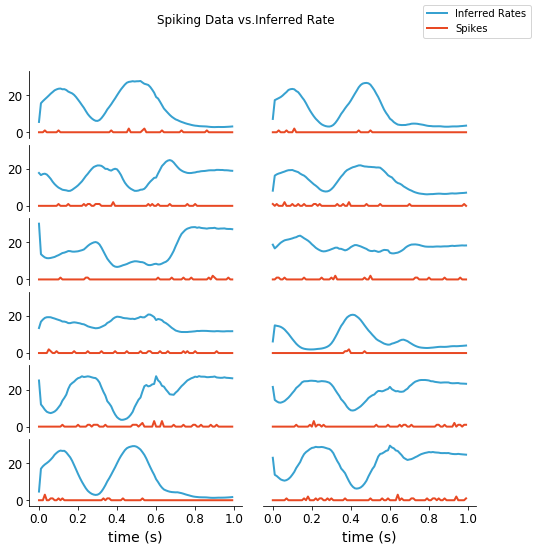

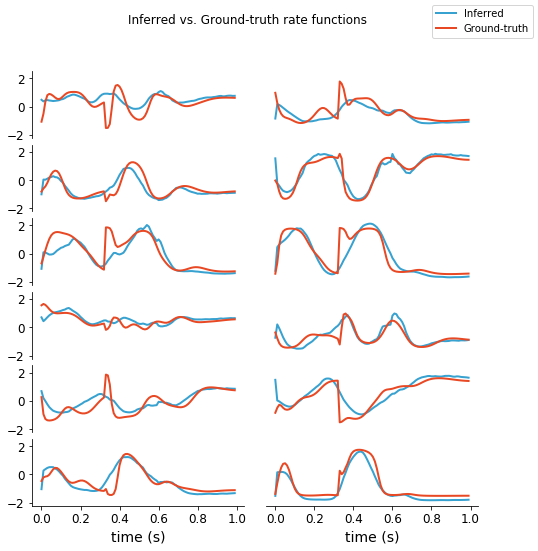

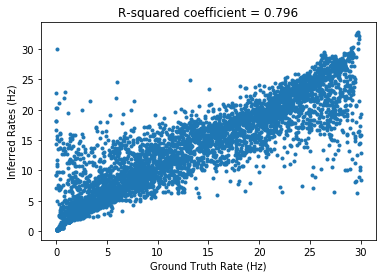

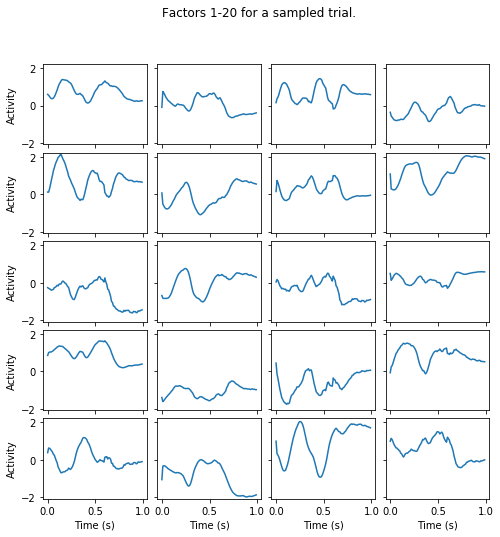

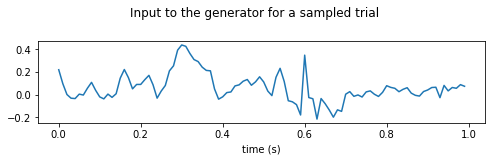

In [12]:
model.plot_summary(data=valid_data, truth=valid_truth)